In [ ]:
"""uncomment it in case gynmasium is not present"""

# %pip install gymnasium[all]
# %pip install shimmy
# %pip install "gymnasium[atari, accept-rom-license]"

"""uncomment it to check if Pong-v0 and others are present or not"""
# # To Check if all modules are working fine 
# import ale_py
# import gymnasium
# import shimmy

# import gymnasium as gym

# req = set(['MountainCar-v0','Pong-v0','CartPole-v0','LunarLander-v2'])
# keys = set(gym.envs.registry.keys())
# for key in req:

#   if(keys.intersection({key}) == set({})):
#       print(key +' not found')   


import gymnasium as gym
import numpy as np
import shimmy #it is compulsory to import
# import ale_py #it's too

env_1 = gym.make("CartPole-v0")
print('\n Environment : CartPole-v0')
 # Print state and action space
print("State space:", env_1.observation_space)
print("Action space:", env_1.action_space)
state, _ = env_1.reset()
done = False
total_reward = 0
step_count = 0
rew_1 = {}
print("Running random agent...")


while not done:
    action = env_1.action_space.sample()  # Random action
    state, reward, done, _, _ = env_1.step(action)
    total_reward += reward
    if reward not in rew_1:
        rew_1[reward] = 0
    rew_1[reward] += 1
    step_count += 1

print(f"Total reward after {step_count} steps: {total_reward}\n")

# Close the environment
env_1.close()
print(f'These are the Rewards(and respective frequencies) after experienting with Random Agent : \n {rew_1}')



 Environment : CartPole-v0
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Running random agent...
Total reward after 15 steps: 15.0

These are the Rewards(and respective frequencies) after experienting with Random Agent : 
 {1.0: 15}


c:\Users\charu\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt



# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, actions):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.forward(state)
        action = torch.multinomial(action_probs, num_samples=1).item()
        return action, torch.log(action_probs[action])

In [3]:
# Set up the environment
# Helper function to compute rewards-to-go
from tqdm import tqdm
def compute_rewards_to_go(rewards, gamma,rtg):

    rewards_to_go = np.zeros_like(rewards, dtype=np.float32)
    cumulative_reward = 0
    for t in reversed(range(len(rewards))):
        cumulative_reward = rewards[t] + gamma * cumulative_reward
        rewards_to_go[t] = cumulative_reward
    if rtg:
        return rewards_to_go
    return [cumulative_reward for i in range(len(rewards_to_go))]
    

class Algo():
    def __init__(self) -> None:
        self.policy = None
        self.optimizer = None
        self.env = None
    
    
    
    def train(self,lr=1e-4,eps=5000,K = 32,gamma=0.995,reward_to_go=True,AdvNorm=True):    
    
        self.env = gym.make("CartPole-v0")
        obs_dim = self.env.observation_space.shape[0]
        print(f'obs_dim : {obs_dim}')
        actions = self.env.action_space.n
        print(f'no of actions : {actions}')

        # Hyperparameters
        # gamma = 0.995
        # lr = 1e-4
        # episodes = 5000
        # batch_size = 32
        avg_rewards = []

        # Initialize the policy network and optimizer
        policy = PolicyNetwork(obs_dim, actions)
        optimizer = optim.Adam(policy.parameters(), lr=lr)

        

        # Training loop

        for episode in tqdm(range(eps)):
            episode_rewards = []
            episode_log_probs = []
            episode_advantages = []
            
            # Collect batch of trajectories
            for _ in range(K):
                state,_ = self.env.reset()
                # print(state)
                log_probs = []
                rewards = []

                while True:
                    action, log_prob = policy.select_action(state)
                    next_state, reward, done, _,_ = self.env.step(action)

                    log_probs.append(log_prob)
                    rewards.append(reward)

                    state = next_state
                    if done:
                        break

                # Compute rewards-to-go for advantage calculation
                rewards_to_go = compute_rewards_to_go(rewards, gamma,reward_to_go)
                
                # Center rewards-to-go (optional: acts as a baseline)
                baseline = np.mean(rewards_to_go)
                advantages = rewards_to_go - baseline

                # Store log_probs and advantages for batch processing
                episode_log_probs.extend(log_probs)
                episode_advantages.extend(advantages)
                episode_rewards.append(sum(rewards))  # For tracking performance

            # Normalize advantages
            advantages = torch.tensor(episode_advantages, dtype=torch.float32)
            if(AdvNorm):
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Compute loss and update policy
            log_probs = torch.stack(episode_log_probs)
            loss = -(log_probs * advantages).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if((episode+1)%1000==0):
                torch.save(policy.state_dict(), f'CartPole_{episode}_rtg{reward_to_go}_Adv{AdvNorm}.pth')

            # Logging
            avg_rewards.append(np.mean(episode_rewards))
        plt.plot(avg_rewards)
        plt.title(f'till episode {episode}')
        plt.show()


c:\Users\charu\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


obs_dim : 4
no of actions : 2


100%|██████████| 1000/1000 [07:31<00:00,  2.21it/s]


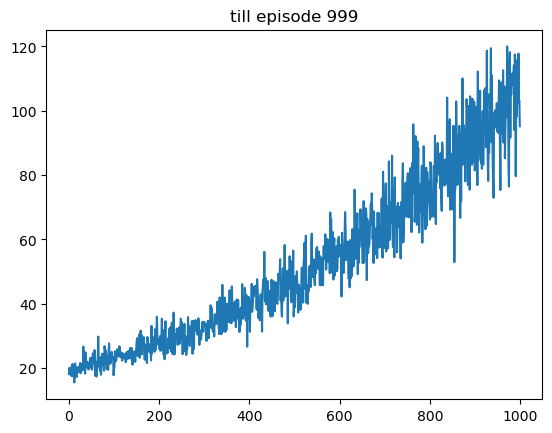

c:\Users\charu\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


obs_dim : 4
no of actions : 2


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


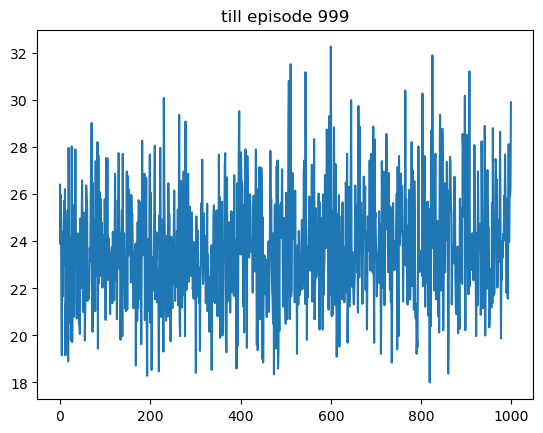

obs_dim : 4
no of actions : 2


100%|██████████| 1000/1000 [03:56<00:00,  4.24it/s]


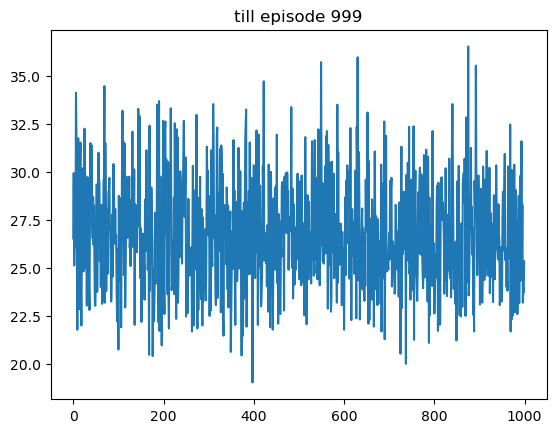

obs_dim : 4
no of actions : 2


100%|██████████| 1000/1000 [11:09<00:00,  1.49it/s]


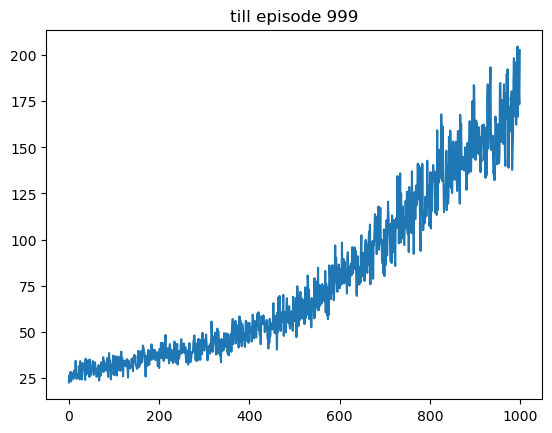

In [4]:
Algorithm = Algo()
Algorithm.train(eps=1000,reward_to_go=True,AdvNorm=True)
Algorithm.train(eps=1000,reward_to_go=False,AdvNorm=True)
Algorithm.train(eps=1000,reward_to_go=False,AdvNorm=False)
Algorithm.train(eps=1000,reward_to_go=True,AdvNorm=False)



In [ ]:
env = gym.make('CartPole-v0', render_mode='human')


test_dqn = PolicyNetwork(4,2) 
test_dqn.load_state_dict(torch.load(r'CartPole_best/CartPole_1599.pth'))
test_dqn.eval() 


for i in range(5):
    state = env.reset()[0]  
    terminated = False      
    truncated = False         

    rewards = 0
    while(not terminated):  
        # Select best action   
        with torch.no_grad():
            action = test_dqn(torch.tensor(state)).argmax().item()

        # Execute action
        state,reward,terminated,truncated,_ = env.step(action)
        rewards += reward

    print(rewards)

env.close()

C:\Users\charu\AppData\Local\Temp\ipykernel_5436\3558571894.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dqn.load_state_dict(torch.load(r'CartPole_best/CartPole

KeyboardInterrupt: 